## Cargamos los datos del paso de preprocesado

In [10]:
import pandas as pd

# Read CSV file into DataFrame df
df = pd.read_csv('preprocessed_reviews.csv', index_col=0)

# Show dataframe
df.head()

,overall,reviewText
2116689,1.0,im disappointed civilization since early day a...
1859378,1.0,didnt even work smh
58133,1.0,crappy item went remove son tv time removed th...
2176318,1.0,man soccer suck horried waste yopur time
1618021,1.0,love persona series hate etrian odyssey series...


# Separamos en conjunto de train y test

Creamos los conjuntos de entrenamiento (75% del total) y test (25%).

In [11]:
from sklearn.model_selection import train_test_split # Modelado

X_train, X_test, y_train, y_test = train_test_split(
    df['reviewText'],
    df['overall'],
    train_size=0.75,
    test_size=0.25,
    random_state=42,
    shuffle=True
)

In [12]:
X_train.iloc[:10]

741289                                   good rb2 still good
2243032                                came really scratched
339849     nunchuck wa used lightly 2 day returned donkey...
709190     doesnt even work always exit click wish could ...
1973154    ok headset havent actually used much yet im wr...
2319980                                        time favorite
236880                                              son love
254894     like sboyer trouble able legitimately purchase...
1479781                             love like use wa younger
2070121    preorder something hope get come outwell frien...
Name: reviewText, dtype: object

### Extracción de features

In [13]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # Modelado

cv = TfidfVectorizer(
    max_df=0.95,
    min_df=3,
    max_features=2500,
    strip_accents='ascii',
    ngram_range=(1, 1)
)
#x = cv.fit_transform(X_train.values.astype('U'))  ## Even astype(str) would work
X_train_ = cv.fit_transform(X_train.values.astype('U'))
X_test_ = cv.fit_transform(X_test.values.astype('U'))
#cv.fit(X_train)

In [14]:
print(list(cv.vocabulary_.items())[:20])
print("Cantidad de vocabulario: ", len(cv.vocabulary_))

[('ps2', 1719), ('version', 2363), ('defective', 585), ('several', 1945), ('stop', 2111), ('30', 24), ('minute', 1413), ('two', 2311), ('dragon', 671), ('supposed', 2153), ('able', 43), ('go', 972), ('needed', 1470), ('bring', 290), ('doe', 651), ('work', 2454), ('tried', 2288), ('every', 765), ('possible', 1659), ('button', 316)]
Cantidad de vocabulario:  2500


## Score IDF de algunas palabras

In [15]:
words_example = [
    'good',
    'game',
    'bad',
    'graphics',
    'bored',
    'incredible',
]

In [16]:
vocab_idf = dict(zip(cv.get_feature_names_out(), cv.idf_))

print('{0:20}{1:20}'.format('Palabra', 'IDF'))
for word in words_example:
    if word not in vocab_idf:
        print('{0:20}{1:20}'.format(word, 'OOV'))
    else:
        print('{0:20}{1:2.3f}'.format(word, vocab_idf[word]))

Palabra             IDF                 
good                2.577
game                OOV                 
bad                 3.633
graphics            OOV                 
bored               5.613
incredible          6.198


## Palabras con el TF-IDF en alguna review

In [17]:
import random

i = random.randint(0, len(X_train))
print('ID: {}'.format(i))
print('Sentiment: {}'.format(y_train.iloc[i]))
print('Review: {}'.format(X_train.iloc[i]))

ID: 69868
Sentiment: 1.0
Review: worked around 5 month intermediate use wont hold charge dont waste money


In [18]:
doc_vector = X_train_[i]
df_tfidf = pd.DataFrame(doc_vector.T.todense(), index=cv.get_feature_names_out(), columns=['tfidf'])
df_tfidf = df_tfidf[df_tfidf['tfidf'] > 0]

top_n = 10
print('Top {} words with highest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[:top_n]))
print('\nTop {} words with lowest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[-top_n:]))

Top 10 words with highest TF_IDF in the review 69868:
              tfidf
channel    0.370416
hill       0.368998
warranty   0.361082
word       0.334445
wonderful  0.327791
mistake    0.309319
armor      0.295945
missile    0.287172
upon       0.248828
dollar     0.222050

Top 10 words with lowest TF_IDF in the review 69868:
              tfidf
channel    0.370416
hill       0.368998
warranty   0.361082
word       0.334445
wonderful  0.327791
mistake    0.309319
armor      0.295945
missile    0.287172
upon       0.248828
dollar     0.222050


## $\chi²$ scores

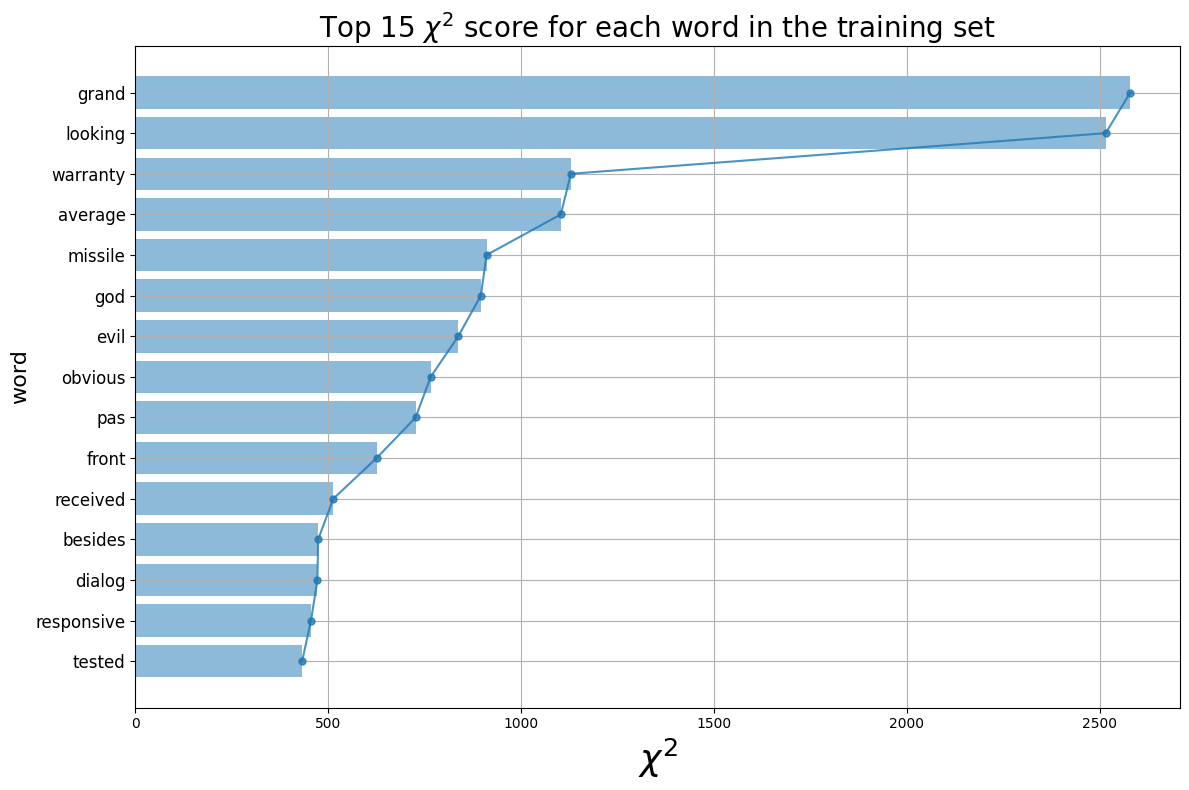

In [19]:
from sklearn.feature_selection import chi2 # Reporte
import matplotlib.pyplot as plt

# Compute the chi-squared score for each word in the training set and show the values
i = 15

chi2score = chi2(X_train_, y_train)[0]
scores = list(zip(cv.get_feature_names_out(), chi2score))
sorted_scores = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*sorted_scores[-i:]))
x = range(len(topchi2[1]))
labels = topchi2[0]

plt.figure(figsize=(12, 8))
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels, fontsize=12)
plt.xlabel('$\chi^2$', fontsize=26)
plt.ylabel('word', fontsize=16)
plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)
plt.grid()
plt.tight_layout()
plt.show();

# Entrenamiento con LogisticRegression

In [20]:
from sklearn.linear_model import LogisticRegression # Reporte
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve # Reporte

c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 10000]

train_acc = list()
test_acc = list()
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=3000)
    lr.fit(X_train_, y_train)
    
    train_predict = lr.predict(X_train_)
    test_predict = lr.predict(X_test_)
    
    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))
    
    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))

Accuracy for C=0.01: 0.23055844920512705
Accuracy for C=0.05: 0.2358349562933104
Accuracy for C=0.25: 0.2378730920784456
Accuracy for C=0.5: 0.23775986231260474
Accuracy for C=1: 0.2380769056569591
Accuracy for C=10: 0.2381674894696318
Accuracy for C=100: 0.23794102993795008
Accuracy for C=1000: 0.23769192445310022
Accuracy for C=10000: 0.23766927849993205


In [21]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict)))

Confussion matrix:
[[3128 1764 1612 1085 1139]
 [2390 2024 1911 1338 1206]
 [2297 1646 1891 1517 1440]
 [2150 1555 1953 1724 1490]
 [2315 1477 1869 1509 1728]]

Classification report:
              precision    recall  f1-score   support

         1.0       0.25      0.36      0.30      8728
         2.0       0.24      0.23      0.23      8869
         3.0       0.20      0.22      0.21      8791
         4.0       0.24      0.19      0.21      8872
         5.0       0.25      0.19      0.22      8898

    accuracy                           0.24     44158
   macro avg       0.24      0.24      0.23     44158
weighted avg       0.24      0.24      0.23     44158

Accuracy score:0.23766927849993205


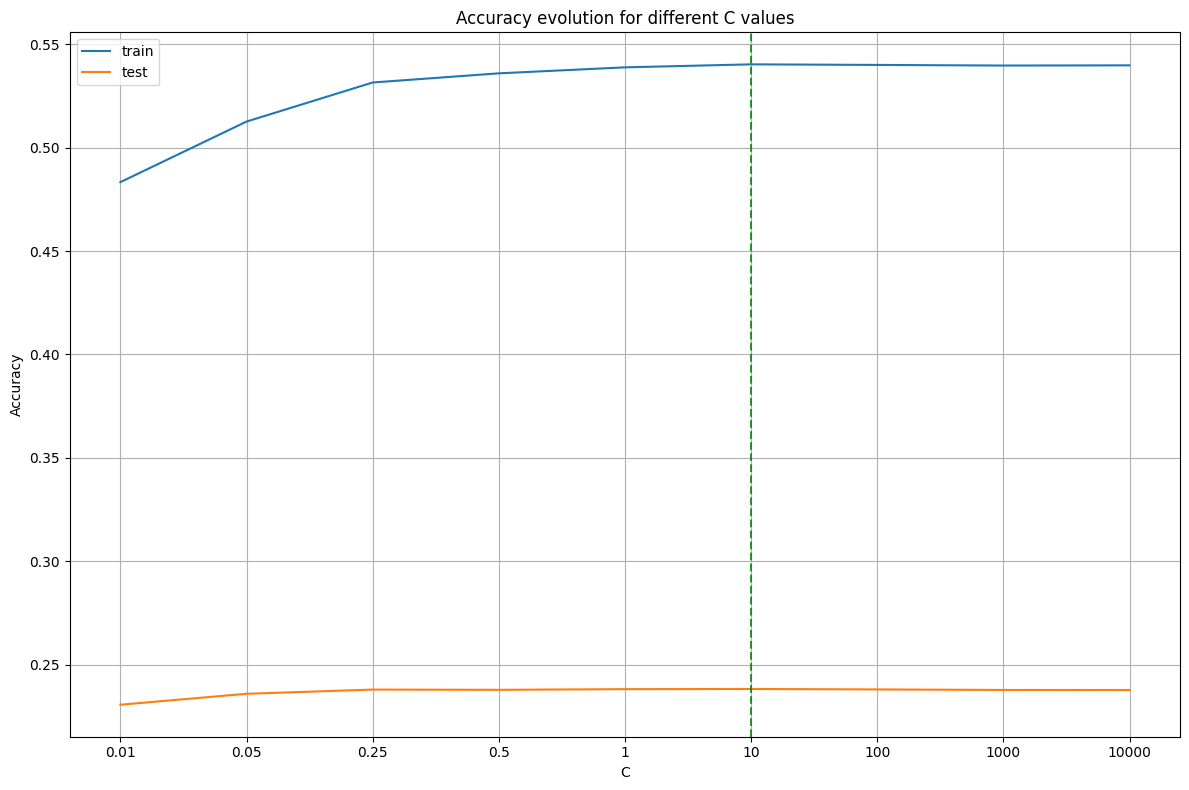

In [22]:
import numpy as np

plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.axvline(np.argmax(test_acc), c='g', ls='--', alpha=0.8)
plt.title('Accuracy evolution for different C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(list(range(len(c_params))), c_params)
plt.tight_layout()
plt.show()

## Predict

In [23]:
def predict_review_sentiment(review_index, model):
    print('Actual sentiment: {}'.format(df.iloc[review_index]['overall']))
    r = df.iloc[review_index]['reviewText']
    print('Prediction: {}'.format(lr.predict(cv.transform([r]))))

In [24]:
for i in random.sample(range(0, len(df)), 5):
    print('\nReview no. {}'.format(i))
    predict_review_sentiment(i, lr)


Review no. 40891
Actual sentiment: 2.0
Prediction: [2.]

Review no. 10231
Actual sentiment: 1.0
Prediction: [1.]

Review no. 173735
Actual sentiment: 5.0
Prediction: [3.]

Review no. 63976
Actual sentiment: 2.0
Prediction: [4.]

Review no. 127342
Actual sentiment: 4.0
Prediction: [4.]


El modelo es bastante malo, en este caso ha acertado 2 de cada 5 predicciones.

## Entrenamiento con GradientBoostingClassifier

In [25]:
from sklearn.ensemble import GradientBoostingClassifier

n_estimators = 32

def classify_gboost(X_train, X_test, y_train, y_test):        
    clf = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=1.0, max_depth=1, random_state=42)

    clf.fit(X_train, y_train)
    
    print("[{}] Accuracy: train = {}, test = {}".format(
            clf.__class__.__name__,
            clf.score(X_train, y_train),
            clf.score(X_test, y_test)))
    
    return clf


clf2 = classify_gboost(X_train_, X_test_, y_train, y_test)

[GradientBoostingClassifier] Accuracy: train = 0.4274035267830183, test = 0.2206395217174691


Vemos que no mejora mucho con GradientBoosting

## Entrenamiento con Deep Learning

In [31]:
# Media de palabras en la reviews.
# RRN necesitamos establcer el tamaño de neruonas 
# primero hacer el análisis para ver el número medio y máxcimo de palabras en las revies.
#si una frase se queda corta, la palabrs restantes se rellenaran de 0. Esto sería negativop
max = 0
mean = []
for example in X_train_.toarray():
  length = len(example)
  mean.append(len(example))
  if length > max:
    max = length

print(sum(mean) / len(mean))
print(max)

2500.0
2500


In [27]:
X_train_

<132472x2500 sparse matrix of type '<class 'numpy.float64'>'
	with 3759148 stored elements in Compressed Sparse Row format>

In [29]:
from tensorflow.keras.utils import pad_sequences

max_words = 500

X_train_dl = pad_sequences(X_train_.toarray(), maxlen=max_words)
X_test_dl = pad_sequences(X_test_.toarray(), maxlen=max_words)

In [32]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, GRUV2, SimpleRNN

vocabulary_size = 2500
embedding_size = 32
model = Sequential()
model.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))
model.add(LSTM(100))
model.add(Dense(1, activation='softmax'))

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           80000     
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 133,301
Trainable params: 133,301
Non-trainable params: 0
_________________________________________________________________
None


In [33]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [35]:
batch_size = 64
num_epochs = 1

X_valid, y_valid = X_train_dl[:batch_size], y_train[:batch_size]  # first batch_size samples
X_train2, y_train2 = X_train_dl[batch_size:], y_train[batch_size:]  # rest for training

model.fit(X_train2, y_train2,
          validation_data=(X_valid, y_valid),
          batch_size=batch_size, epochs=num_epochs)

2023-03-10 21:20:27.078074: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-10 21:20:27.741426: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-10 21:20:28.042568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-10 21:20:29.886879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2069/2069 [==============================] - ETA: 0s - loss: -224.2862 - accuracy: 0.2008

2023-03-10 21:28:15.814173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-10 21:28:15.874718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2069/2069 [==============================] - 470s 224ms/step - loss: -224.2862 - accuracy: 0.2008 - val_loss: -401.7770 - val_accuracy: 0.2031
